# Исходные данные

In [1]:
from graph.graph import graph
import matplotlib.pyplot as plt
import networkx as nx
from tqdm.notebook import tqdm

mpl_params = {

    'figure.figsize': (25, 13),
}
plt.rcParams.update(mpl_params)
G = graph.graph

## Палитра цветов
### Палитра узлов

In [2]:
import seaborn

node_palette = seaborn.color_palette('muted', 3)
node_palette

[(0.2823529411764706, 0.47058823529411764, 0.8156862745098039),
 (0.9333333333333333, 0.5215686274509804, 0.2901960784313726),
 (0.41568627450980394, 0.8, 0.39215686274509803)]

### Палитра дуг

In [3]:
edge_palette = seaborn.color_palette('pastel', 3)
edge_palette

[(0.6313725490196078, 0.788235294117647, 0.9568627450980393),
 (1.0, 0.7058823529411765, 0.5098039215686274),
 (0.5529411764705883, 0.8980392156862745, 0.6313725490196078)]

In [4]:
nodes = G.nodes()
pos = nx.get_node_attributes(G, 'pos')
nodes_types = nx.get_node_attributes(G, 'type')
edges_types = nx.get_edge_attributes(G, 'type')

## Исходный граф
Тип ребер и вершин соответствует типу обслуживаемых беспилотников

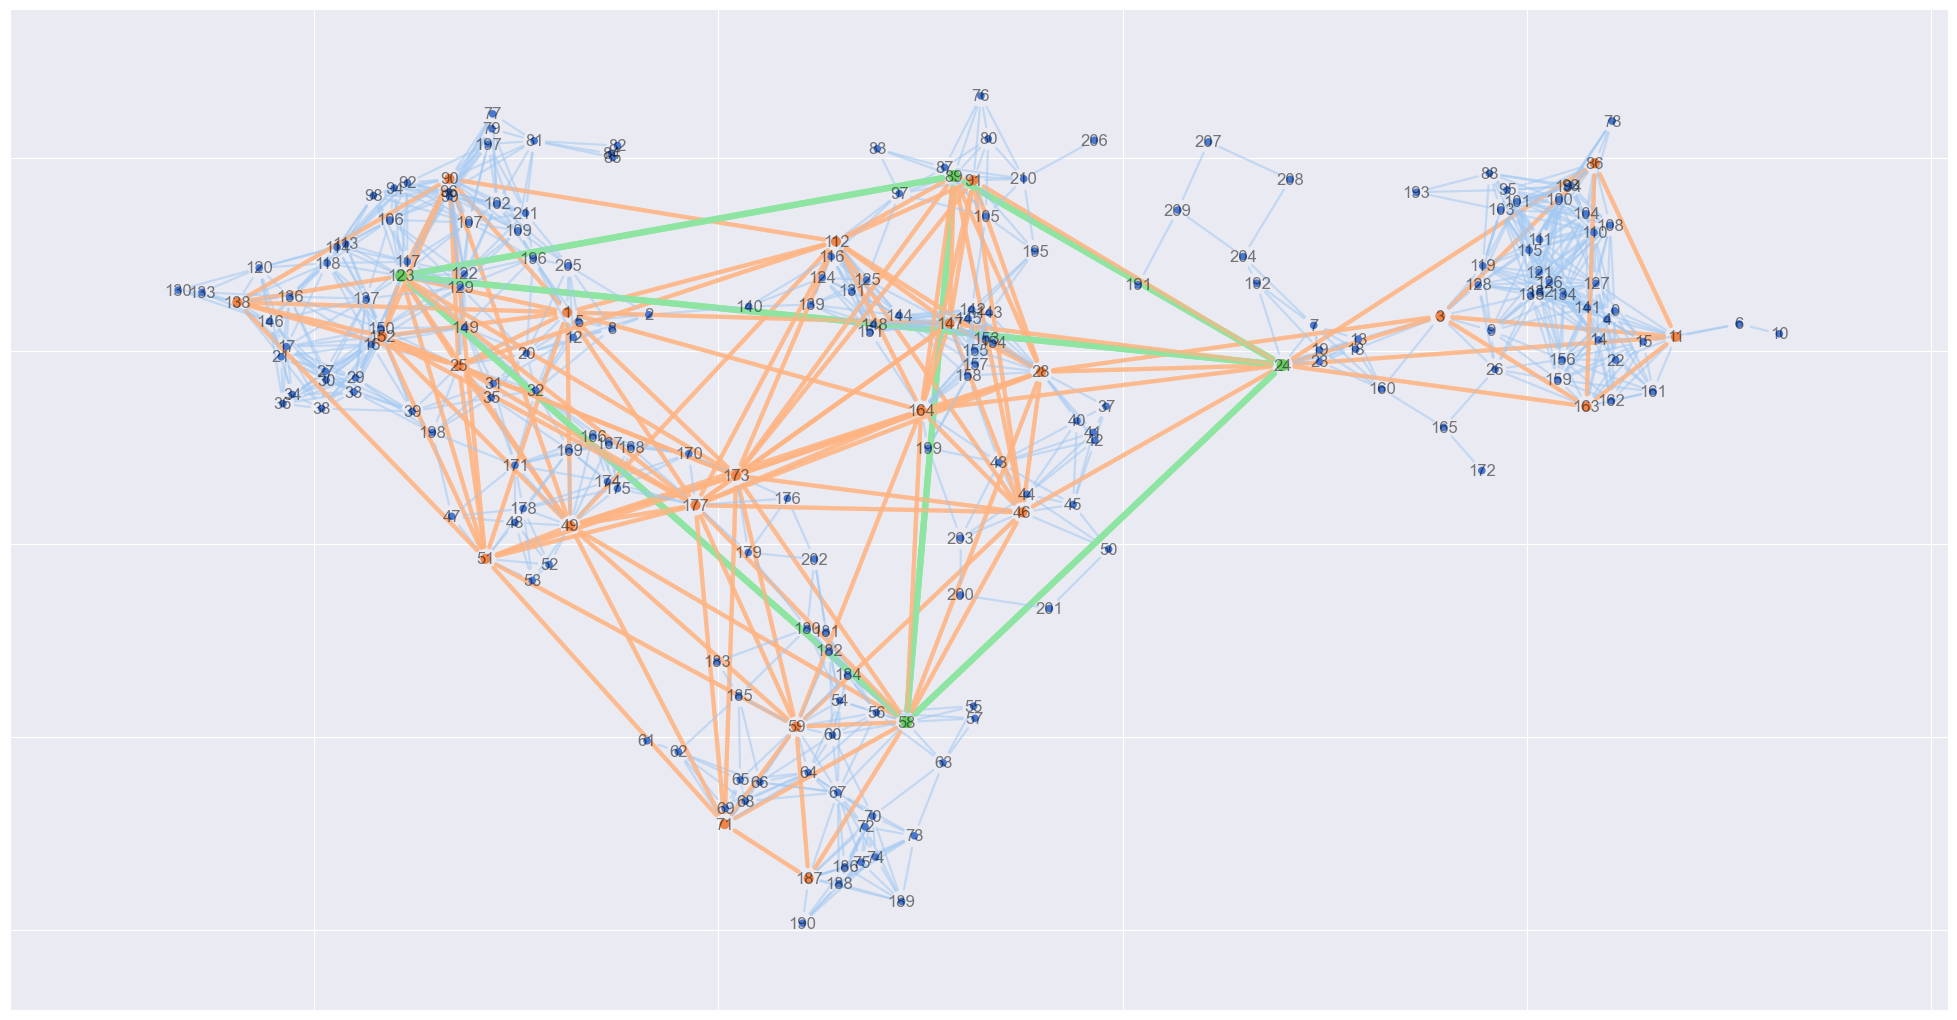

In [5]:
from typing import List

def draw_graph(what: List[str] = None, arrowstyle='-'):
    if what is None or 'edges' in what:
        nx.draw_networkx_edges(G, pos=pos,
                               edge_color=list(map(lambda x: edge_palette[x], edges_types.values())),
                               width=list(map(lambda x: (x + 1) * 1.5, edges_types.values())),
                               alpha=list(map(lambda x: (x + 1) / 3, edges_types.values())),
                               arrows=True,
                               arrowstyle=arrowstyle)
    if what is None or 'nodes' in what:
        nx.draw_networkx_nodes(G, pos=pos,
                               node_color=list(map(lambda x: node_palette[x], nodes_types.values())),
                               node_size=list(map(lambda x: (x + 1) * 20, nodes_types.values())))
    if what is None or 'labels' in what:
        nx.draw_networkx_labels(G, pos=pos,
                                alpha=0.5)


draw_graph()

## Функция стоимости перевозки N грузов на ребрах разных типов
При фиксированном расстоянии

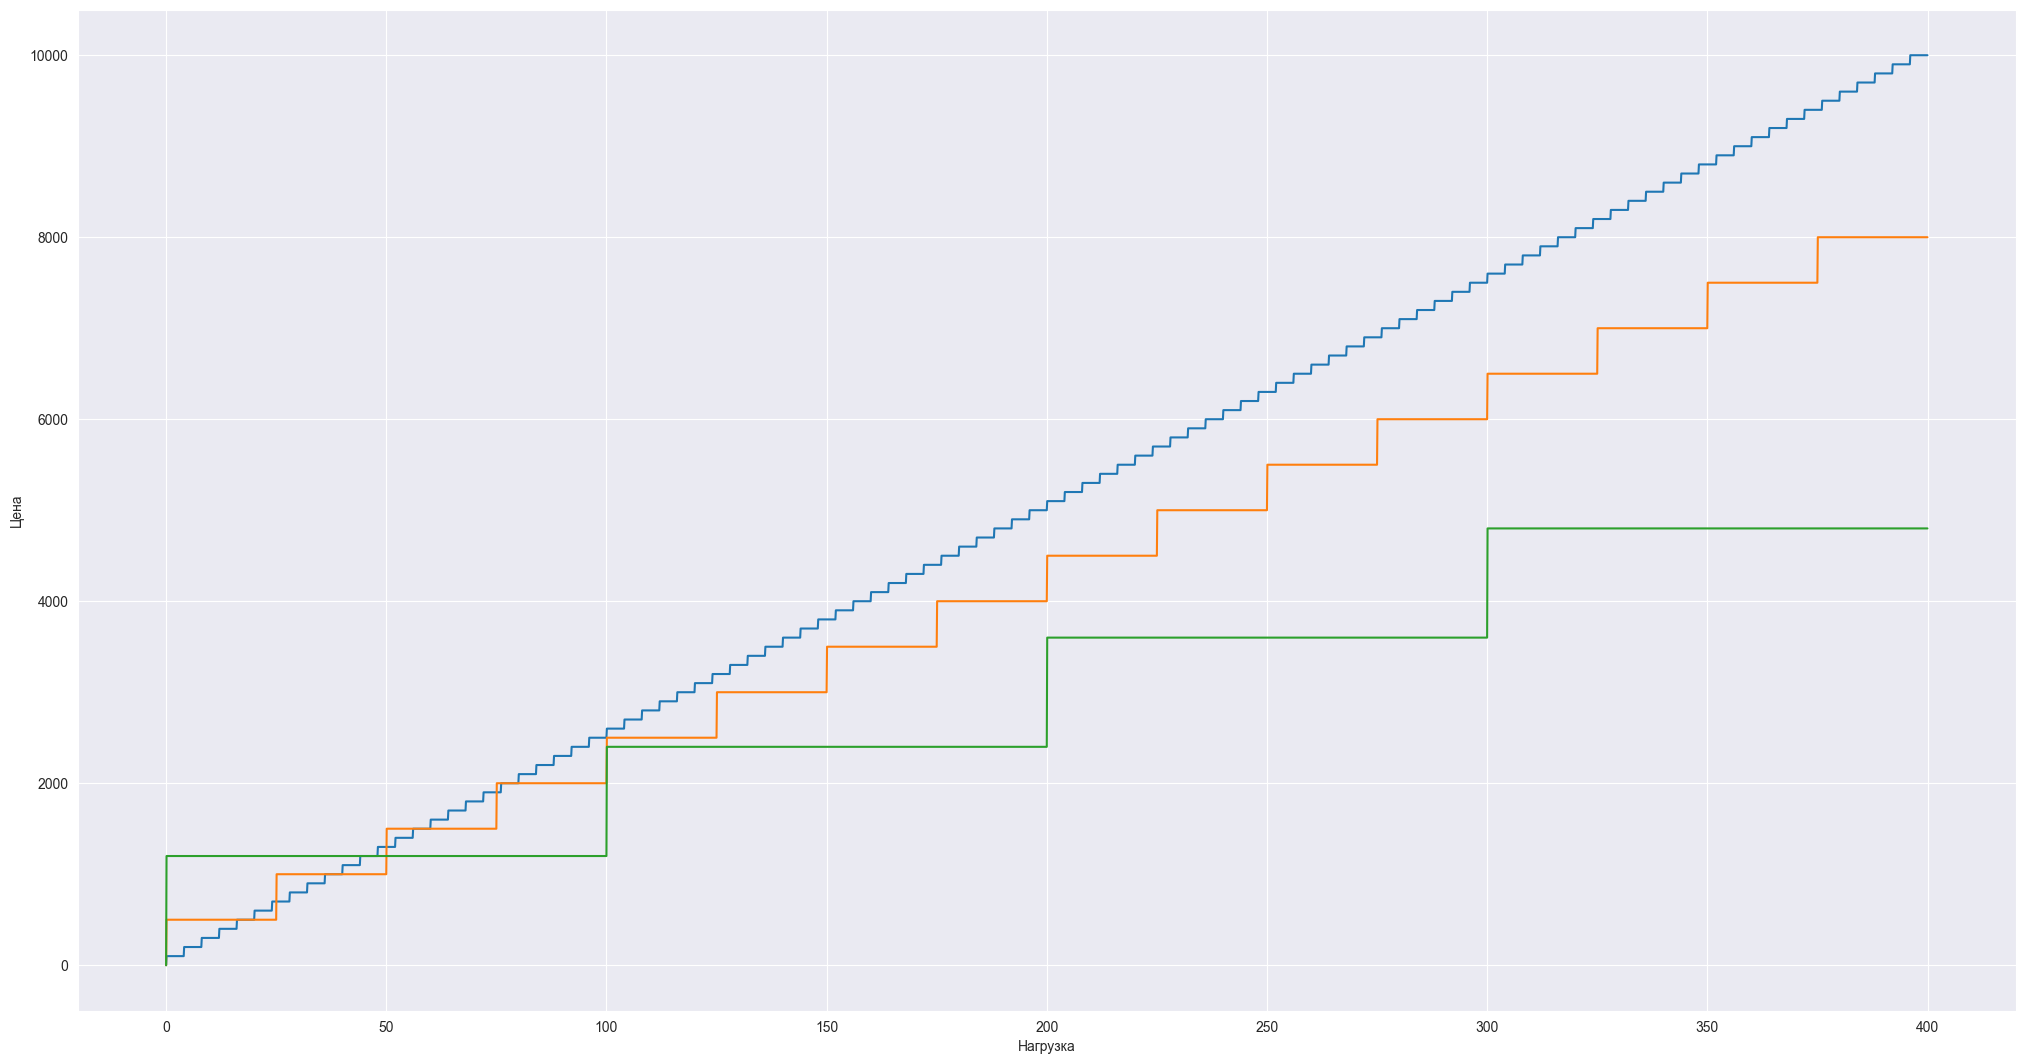

In [6]:
import numpy as np


def draw_price_function(edge_type, dist, max_payload):
    payload = np.arange(-0.01, max_payload, 0.1)
    price = np.array(graph.calc_price(edge_type, dist, payload))
    #
    plt.xlabel('Нагрузка')
    plt.ylabel('Цена')

    plt.plot(payload, price)


draw_price_function(0, 100, 400)
draw_price_function(1, 100, 400)
draw_price_function(2, 100, 400)

## Генерация 100 000 заказов
А также распределение по размеру партии

(array([1.0737e+04, 1.1946e+04, 8.8130e+03, 4.9610e+03, 2.2670e+03,
        8.2600e+02, 2.7900e+02, 7.2000e+01, 2.4000e+01, 5.0000e+00]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.]),
 <BarContainer object of 10 artists>)

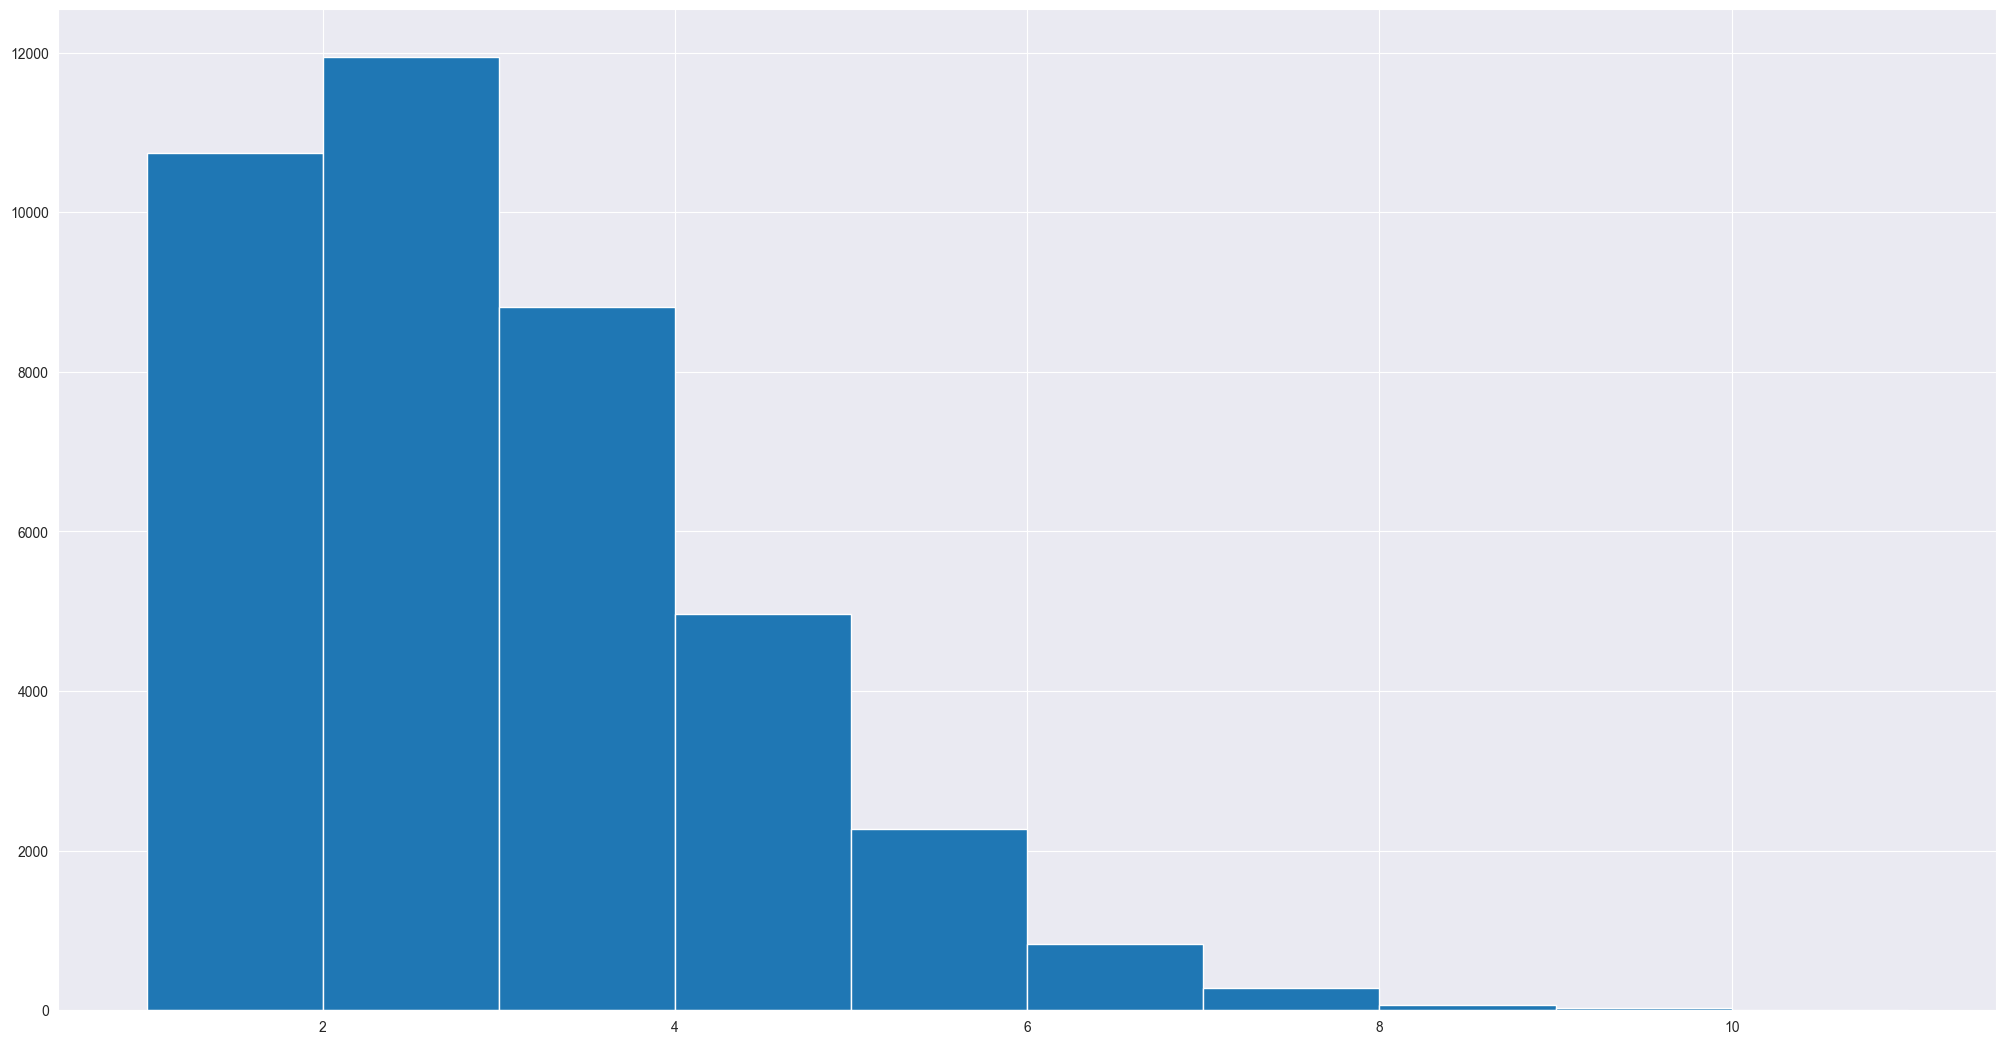

In [7]:
import random
from collections import Counter
random.seed(42)

orders = []
def edges_from_path(p):
    result = []
    for j in range(len(p) - 1):
        result.append((p[j], p[j + 1]))
    return result

for i in range(100000):
    orders.append(tuple(random.sample(G.nodes(), 2)))
plt.hist(Counter(orders).values())

# Простейший алгоритм планирования путей
Путь для каждого заказа является кратчайшим путем, который формируется на основе априорной информации о длине ребра
## Планирование путей

In [12]:
from itertools import chain
paths = [nx.shortest_path(G, x[0], x[1], 'dist') for x in tqdm(orders)]
used_edges = list(chain(*[edges_from_path(x) for x in tqdm(paths)]))
print('Used edges count: ', len(used_edges))
used_edges_payload = Counter(used_edges)
used_edges_payload

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Used edges count:  498724


Counter({(163, 24): 1077,
         (24, 28): 730,
         (6, 11): 883,
         (11, 24): 1041,
         (24, 58): 2891,
         (58, 63): 850,
         (63, 73): 440,
         (73, 189): 203,
         (70, 67): 444,
         (67, 66): 63,
         (66, 62): 60,
         (57, 58): 428,
         (58, 177): 373,
         (177, 174): 650,
         (174, 169): 214,
         (169, 35): 260,
         (188, 67): 337,
         (67, 58): 1591,
         (58, 24): 2889,
         (24, 3): 8547,
         (3, 26): 414,
         (173, 59): 63,
         (59, 67): 1442,
         (67, 74): 573,
         (74, 189): 167,
         (139, 144): 6087,
         (144, 147): 4808,
         (147, 24): 7455,
         (3, 9): 2320,
         (9, 156): 1602,
         (156, 22): 431,
         (151, 147): 152,
         (3, 128): 3786,
         (128, 115): 2662,
         (115, 108): 384,
         (8, 2): 791,
         (2, 140): 7346,
         (140, 139): 6809,
         (24, 7): 358,
         (23, 24): 1441,
         

## Визуализация нагрузки на каждое ребро
Менее прозрачное - более нагруженное

8623


  0%|          | 0/2339 [00:00<?, ?it/s]

 ...]

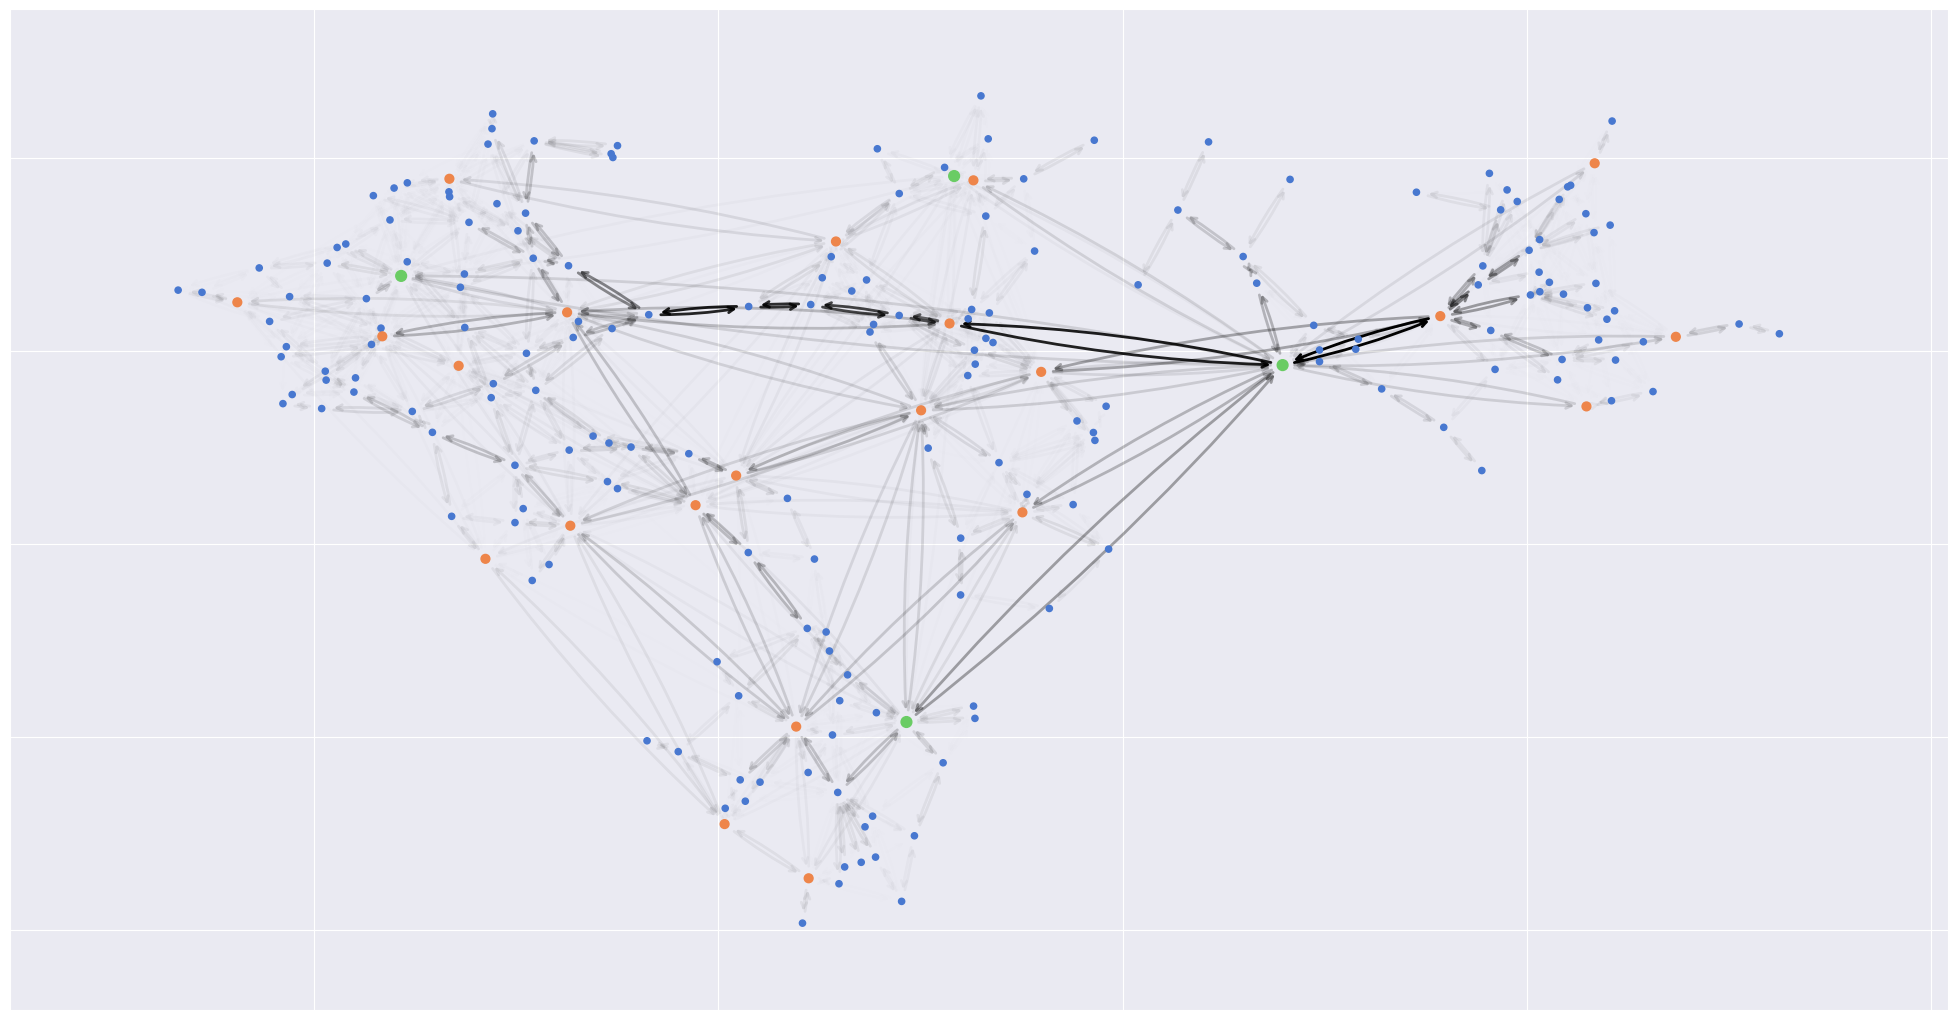

In [13]:
edge_colors = {}
max_edges_payload = max(used_edges_payload.values())
print(max_edges_payload)
for edge, payload in tqdm(used_edges_payload.items()):
    # edge_type = G[edge[0]][edge[1]]['type']
    # edge_colors[edge] = (*node_palette[edge_type], payload / max(used_edges_payload.values()))
    edge_colors[edge] = (0, 0, 0, payload / max_edges_payload)
draw_graph(['nodes'])
nx.draw_networkx_edges(G, pos=pos, arrows=True, width=2, edge_color=edge_colors.values(), edgelist=edge_colors.keys(), connectionstyle='arc3, rad = 0.05', arrowstyle='->')

## Расчет стоимости для данного решения

In [15]:
edge_prices = {}
for edge, payload in tqdm(used_edges_payload.items()):
    edge_attributes = G[edge[0]][edge[1]]
    price = graph.calc_price(edge_attributes['type'], edge_attributes['dist'], payload)
    edge_prices[edge] = price
simplest_algorithm_price = sum(edge_prices.values())
print('Price: ', simplest_algorithm_price)
edge_prices

  0%|          | 0/2339 [00:00<?, ?it/s]

Price:  68639.5957341663


{(163, 24): 333.9543948804972,
 (24, 28): 179.20691783522125,
 (6, 11): 70.66915171982974,
 (11, 24): 409.6101484936607,
 (24, 58): 913.0581154099675,
 (58, 63): 59.30333897193435,
 (63, 73): 44.85858286404082,
 (73, 189): 17.637956822999804,
 (70, 67): 23.728476057260607,
 (67, 66): 6.209462095866273,
 (66, 62): 6.9482060994187025,
 (57, 58): 36.6472900717099,
 (58, 177): 115.00238959473815,
 (177, 174): 73.74820571275043,
 (174, 169): 13.504238334685802,
 (169, 35): 31.143506236132122,
 (188, 67): 40.233841135293225,
 (67, 58): 198.47755211146645,
 (58, 24): 913.0581154099675,
 (24, 3): 1402.6849826532675,
 (3, 26): 40.22042517925392,
 (173, 59): 20.021436143543706,
 (59, 67): 143.788475228337,
 (67, 74): 55.272002292661575,
 (74, 189): 11.055295176520707,
 (139, 144): 671.3852534645372,
 (144, 147): 303.9359918153834,
 (147, 24): 2483.626833839221,
 (3, 9): 151.21752528943082,
 (9, 156): 153.78632318138602,
 (156, 22): 28.567837370021355,
 (151, 147): 15.446885336533319,
 (3, 128): 

# Жадный алгоритм
Рекуррентный алгоритм, где путь для каждого заказа является кратчайшим путем.
Кратчайший путь формируется на основе апостериорной информации о стоимости перелета по ребру.
Стоимость перелета по ребру формируется исходя из нагрузки на ребро
$$ Price=f(Distance, Edgetype, Payload)$$
Нагрузка на ребро формируется на основе информации об уже запланированных заказах и текущем заказе
$$ Payload = \sum_{i=0}^{Current-1}weight_i + weight_{Current}$$
Последовательность планирования путей формируется либо по мере поступления заказов, либо в случайном порядке


In [30]:
#FIXME в качестве веса надо брать не фактическую стоимость а стоимость одного перелета при условии добавления заказа
greedy_payload = dict(zip(list(G.edges) + list(map(lambda x: x[::-1], G.edges)), [0] * 2 * len(G.edges)))
paths = []
used_edges = []
i = 0
greedy_part = 0.1
actual_price = dict(zip(list(G.edges) + list(map(lambda x: x[::-1], G.edges)), [0] * 2 * len(G.edges)))
for order in tqdm(orders):
    greedy_price = {}
    for edge, payload in greedy_payload.items():
        edge_attributes = G[edge[0]][edge[1]]
        greedy_price[edge] = graph.calc_price(edge_attributes['type'], edge_attributes['dist'], payload + 1)
    delta_price = {}
    for edge, price in greedy_price.items():
        delta_price[edge] = price - actual_price[edge]
    nx.set_edge_attributes(G, delta_price, 'greedy_price')

    path = nx.shortest_path(G, order[0], order[1], 'greedy_price' if i >= (1 - greedy_part) * len(orders) else 'dist')
    paths.append(path)
    path_edges = edges_from_path(path)
    for edge in path_edges:
        greedy_payload[edge] += 1
        used_edges.append(edge)
    for edge, payload in greedy_payload.items():
        edge_attributes = G[edge[0]][edge[1]]
        actual_price[edge] = graph.calc_price(edge_attributes['type'], edge_attributes['dist'], payload)
    i += 1
print('Used edges count: ', len(used_edges))
used_edges_payload = Counter(used_edges)
used_edges_payload


  0%|          | 0/100000 [00:00<?, ?it/s]

Used edges count:  611471


Counter({(163, 24): 974,
         (24, 28): 2404,
         (6, 11): 879,
         (11, 24): 949,
         (24, 58): 2599,
         (58, 63): 933,
         (63, 73): 511,
         (73, 189): 205,
         (70, 67): 575,
         (67, 66): 71,
         (66, 62): 63,
         (57, 58): 423,
         (58, 177): 349,
         (177, 174): 603,
         (174, 169): 315,
         (169, 35): 303,
         (188, 67): 307,
         (67, 58): 1483,
         (58, 24): 2699,
         (24, 3): 7724,
         (3, 26): 487,
         (173, 59): 74,
         (59, 67): 1315,
         (67, 74): 523,
         (74, 189): 187,
         (139, 144): 5615,
         (144, 147): 4779,
         (147, 24): 6724,
         (3, 9): 2227,
         (9, 156): 1467,
         (156, 22): 399,
         (151, 147): 207,
         (3, 128): 3987,
         (128, 115): 2443,
         (115, 108): 347,
         (8, 2): 1751,
         (2, 140): 8565,
         (140, 139): 7786,
         (24, 7): 415,
         (23, 24): 2275,
         

In [31]:
G[1][2], G[2][1]

({'index': 18,
  'dist': 0.4040782226252664,
  'type': 0,
  'greedy_price': 0.40407822262525883},
 {'index': -18,
  'dist': 0.4040782226252664,
  'type': 0,
  'greedy_price': 0.40407822262527304})

8899


  0%|          | 0/2384 [00:00<?, ?it/s]

 ...]

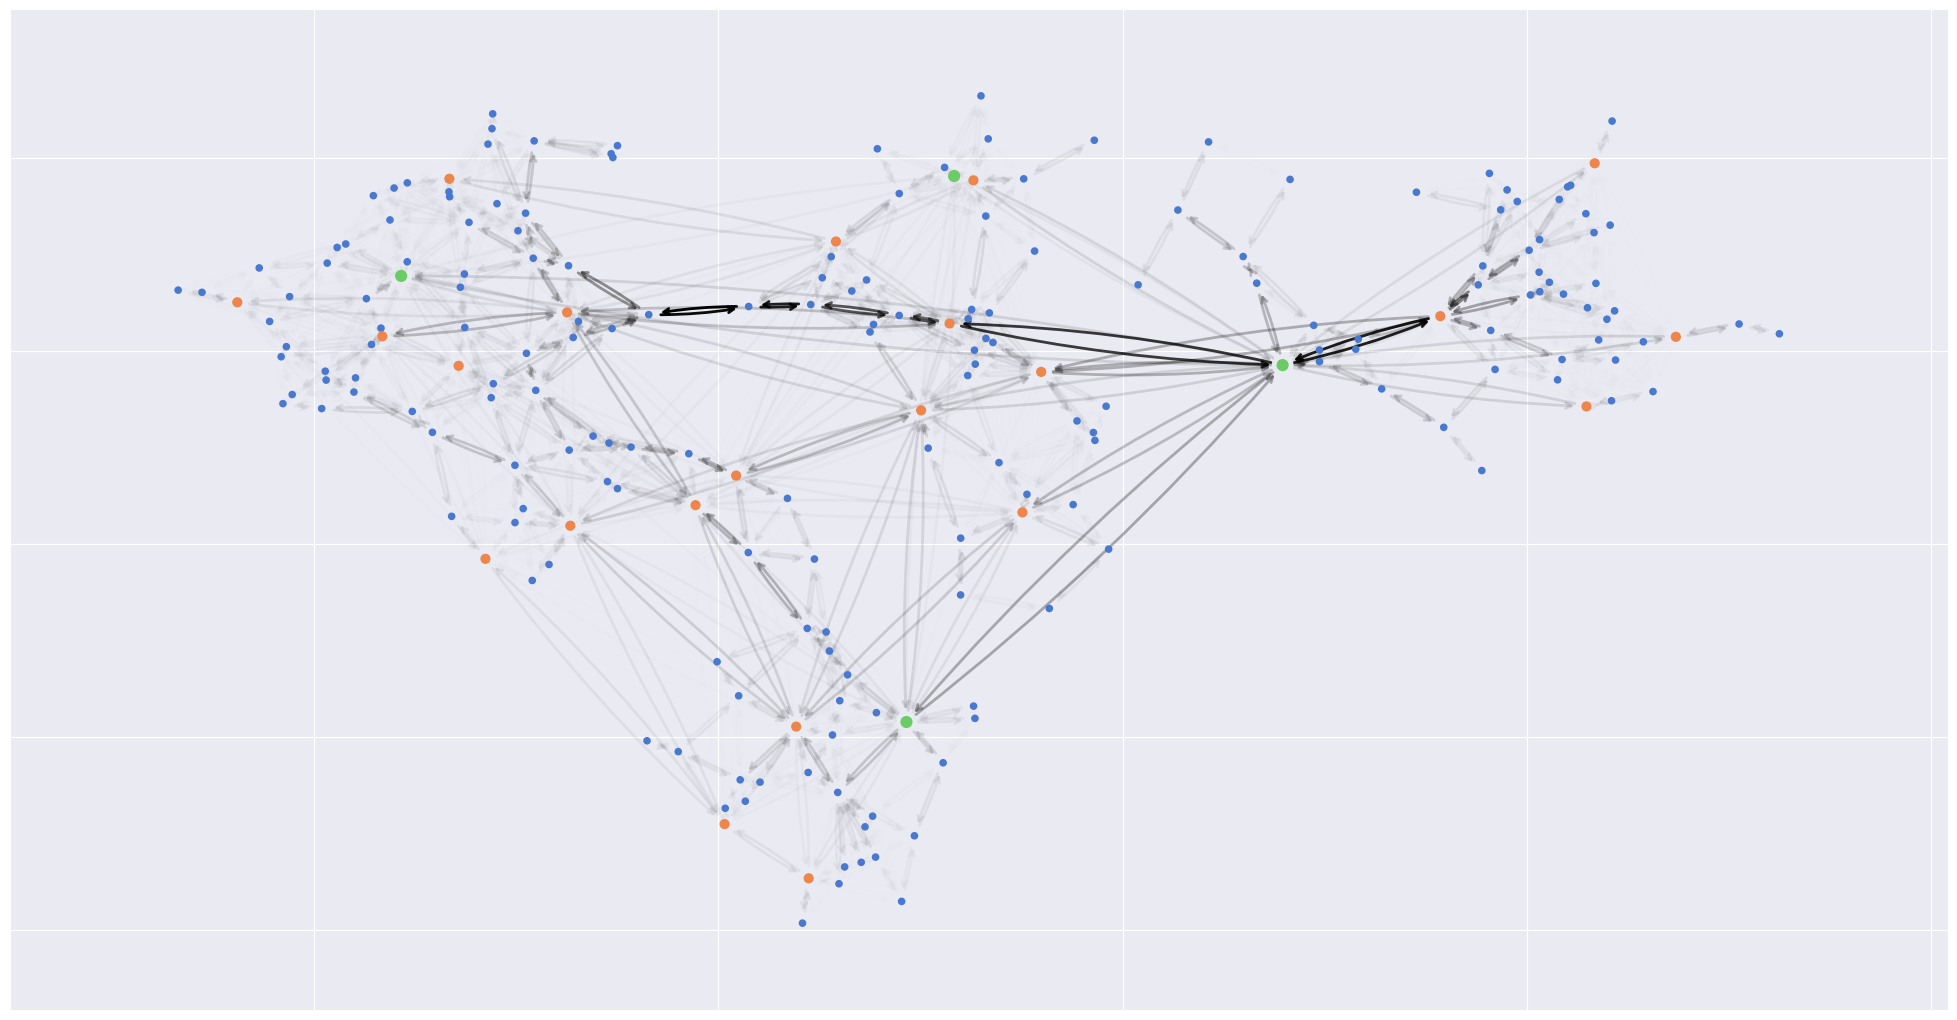

In [32]:
edge_colors = {}
max_edges_payload = max(used_edges_payload.values())
print(max_edges_payload)
for edge, payload in tqdm(used_edges_payload.items()):
    # edge_type = G[edge[0]][edge[1]]['type']
    # edge_colors[edge] = (*node_palette[edge_type], payload / max(used_edges_payload.values()))
    edge_colors[edge] = (0, 0, 0, payload / max_edges_payload)
draw_graph(['nodes'])
nx.draw_networkx_edges(G, pos=pos, arrows=True, width=2, edge_color=edge_colors.values(), edgelist=edge_colors.keys(), connectionstyle='arc3, rad = 0.05', arrowstyle='->')

In [33]:
edge_prices = {}
for edge, payload in tqdm(used_edges_payload.items()):
    edge_attributes = G[edge[0]][edge[1]]
    price = graph.calc_price(edge_attributes['type'], edge_attributes['dist'], payload)
    edge_prices[edge] = price
greedy_algorithm_price = sum(edge_prices.values())
print('Price: ', greedy_algorithm_price)
edge_prices

  0%|          | 0/2384 [00:00<?, ?it/s]

Price:  72232.72500133474


{(163, 24): 296.0050318258953,
 (24, 28): 579.4357010005486,
 (6, 11): 70.34938180254545,
 (11, 24): 370.5996581609311,
 (24, 58): 818.6038276089364,
 (58, 63): 65.15014703958985,
 (63, 73): 51.72881627565067,
 (73, 189): 17.98379911364686,
 (70, 67): 30.508040645049356,
 (67, 66): 6.985644857849557,
 (66, 62): 6.9482060994187025,
 (57, 58): 35.96863655186342,
 (58, 177): 107.3355636217556,
 (177, 174): 68.31888995475654,
 (174, 169): 19.756200526669968,
 (169, 35): 35.86221930221275,
 (188, 67): 36.44712667550092,
 (67, 58): 185.01299455616595,
 (58, 24): 850.0885902092801,
 (24, 3): 1267.338186081461,
 (3, 26): 47.1816526141248,
 (173, 59): 20.021436143543706,
 (59, 67): 131.04268241031266,
 (67, 74): 50.28216875235185,
 (74, 189): 12.371401745154124,
 (139, 144): 619.3330459028975,
 (144, 147): 301.91480483739247,
 (147, 24): 2234.4335060292656,
 (3, 9): 144.97101822067637,
 (9, 156): 140.7470838093982,
 (156, 22): 26.45170126853829,
 (151, 147): 20.595847115377758,
 (3, 128): 247.0

# Генетический алгоритм

##  K кратчайших путей
Для примера - между вершинами 10 и 130
Красным отмечен кратчайший путь

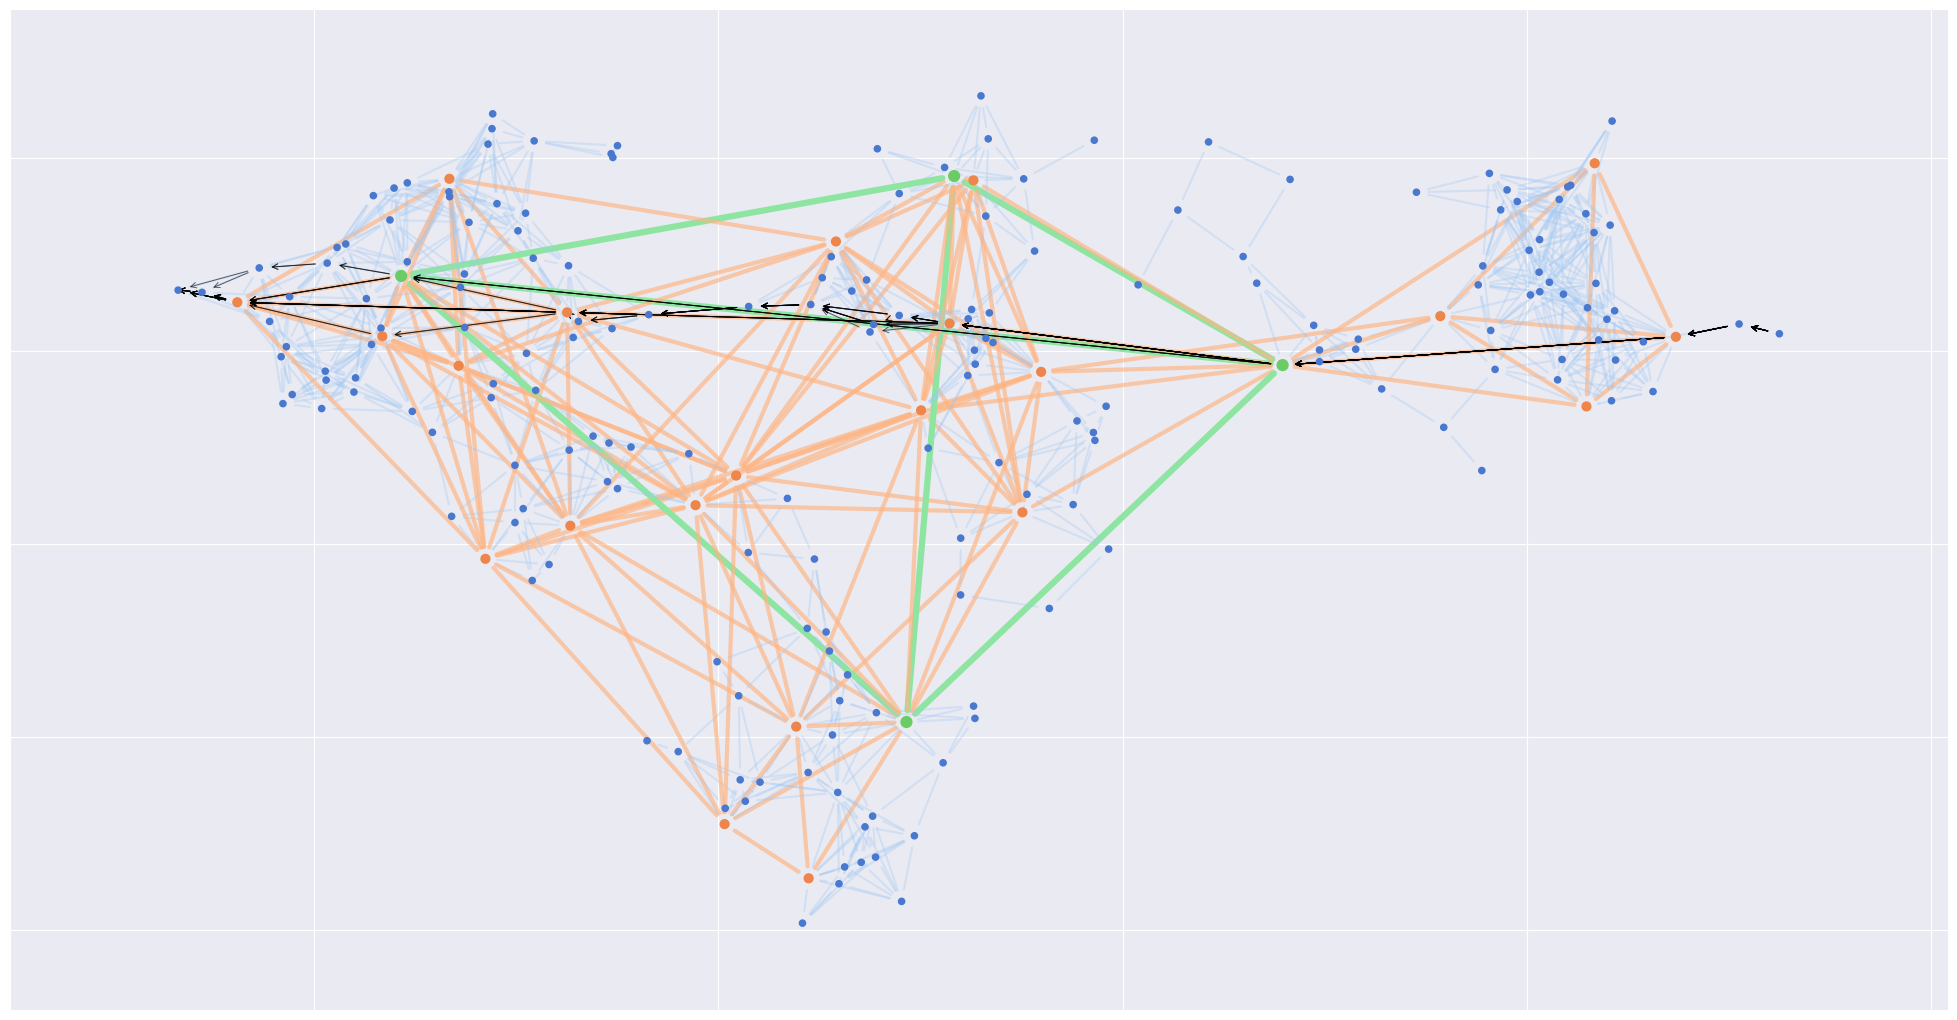

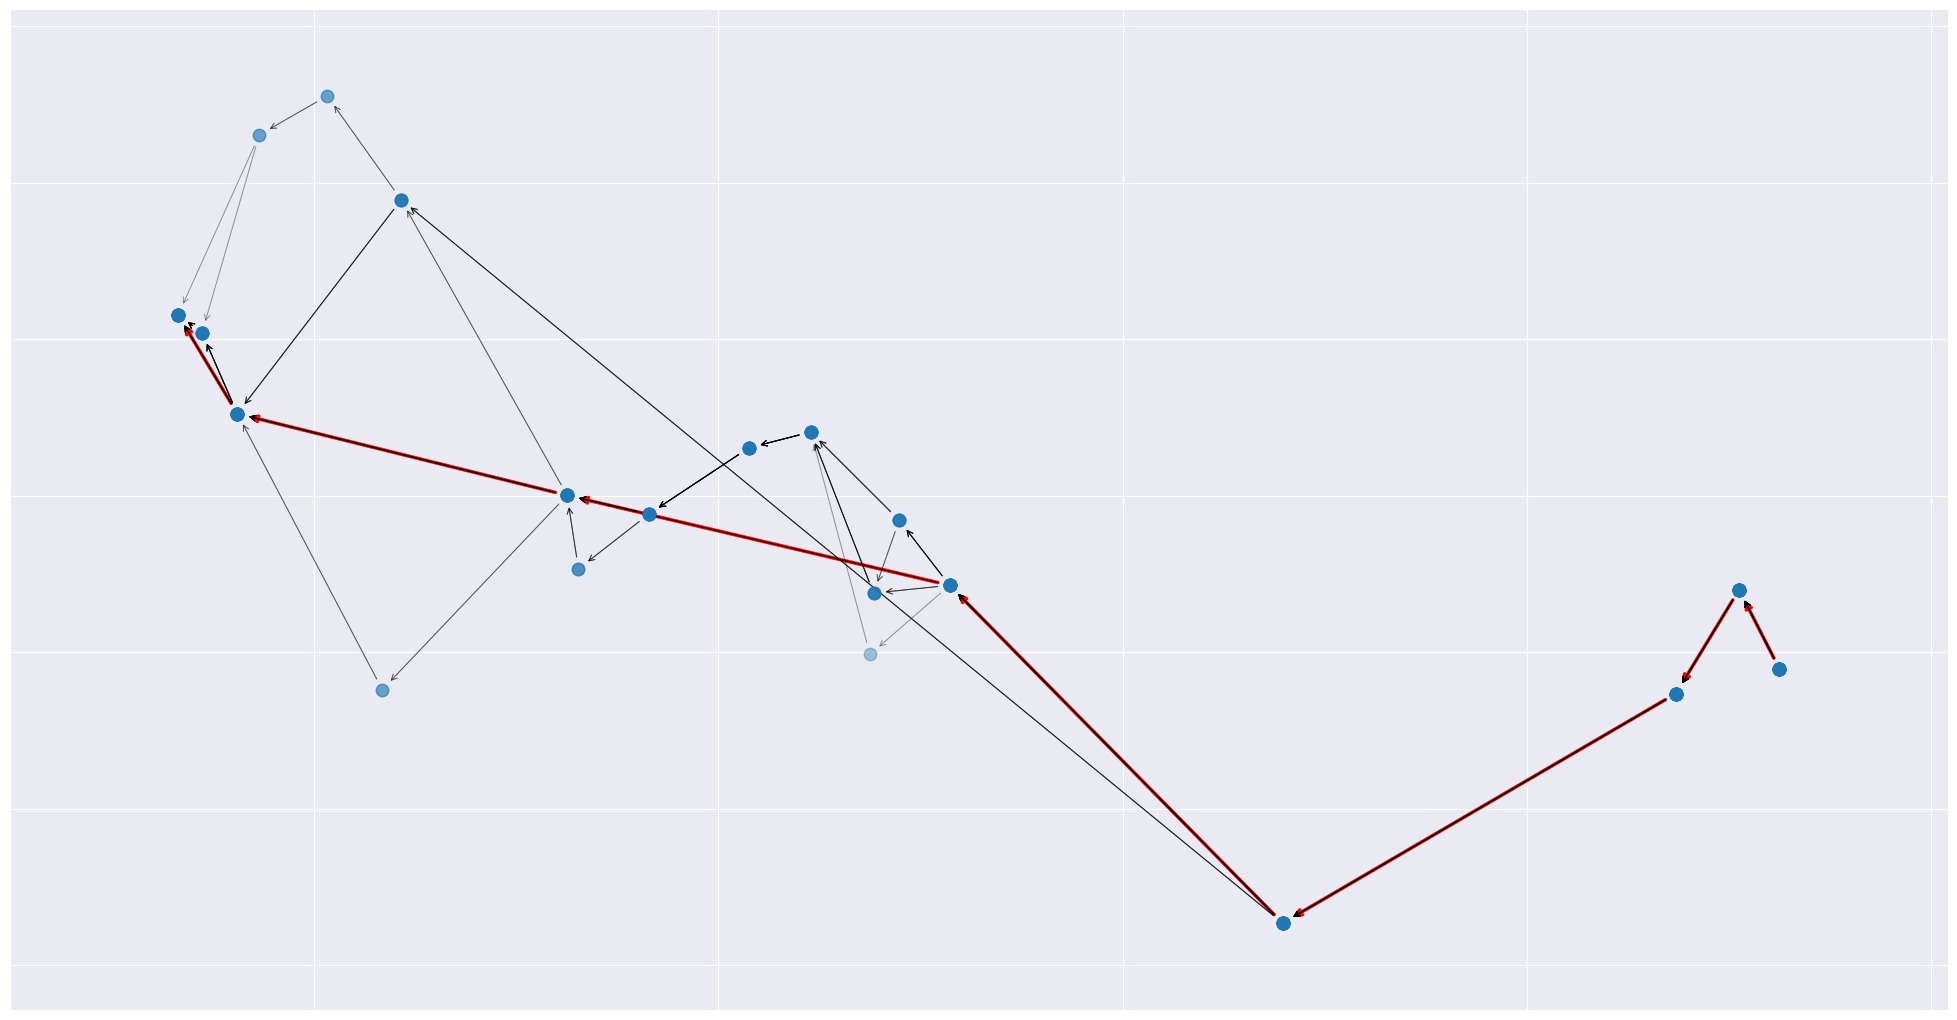

In [152]:

from logistics.k_shortest import k_shortest



paths = k_shortest(G, 10, 130, 'dist')
plt.figure(1)
draw_graph(['nodes', 'edges'])
for path in paths:
    nx.draw_networkx_edges(G, pos=pos, edgelist=edges_from_path(path), alpha=0.6, arrows=True, arrowstyle='->', width=0.7)
plt.figure(2)
for i, path in enumerate(paths):
    nx.draw_networkx_edges(G, pos=pos, edgelist=edges_from_path(path), alpha=1 if i == 0 else 0.4,
                           arrows=True, arrowstyle='->', width=2.5 if i == 0 else 0.7, edge_color='red' if i == 0 else 'k')
    nx.draw_networkx_nodes(G, pos=pos, nodelist=path, alpha=0.4, node_size=80)
    # nx.draw_networkx_labels(G, pos=pos, labels=dict(zip(path, path)), horizontalalignment='left')